# Onside Kick Research

## 1. Load the data 

In [274]:
import json
import re
from os.path import join
import os
import unicodedata

import pandas as pd
import numpy as np
from tqdm import tqdm
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, auc
import shap

import cfbd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

with open('../config.json') as f:
    configuration = cfbd.Configuration(
        access_token = json.load(f)['CFBD_API_KEY']
    )

In [2]:
YEARS = range(2013, 2025)
DATA_DIR = '../data'

In [3]:
def convert_to_snake_case(cols):
    cols_new = []
    for c in cols:
        s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', c)
        cols_new.append(re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower())
    return cols_new

In [4]:
# Load games data
all_dfs = []
id_cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site', 'venue_id']
home_cols = ['home_id', 'home_team', 'home_conference', 'home_division', 'home_points', 'home_pregame_elo']
away_cols = ['away_id', 'away_team', 'away_conference', 'away_division', 'away_points', 'away_pregame_elo']

games_dir = join(DATA_DIR, 'games')
if not os.path.exists(games_dir):
    os.makedirs(games_dir)


for year in YEARS:
    file_path = join(games_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} games data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_games(year=year)
        tmp = pd.DataFrame([val.to_dict() for val in data])
        tmp.columns = convert_to_snake_case(tmp.columns)
        tmp = tmp[id_cols + [
                            'home_id','home_team','home_conference','home_classification','home_points','home_pregame_elo',
                            'away_id','away_team','away_conference','away_classification','away_points','away_pregame_elo']]
        tmp['season_type'] = tmp['season_type'].apply(lambda x: x.value)
        tmp = tmp.assign(
            home_division=tmp['home_classification'].apply(lambda x: x.value if x is not None else None),
            away_division=tmp['away_classification'].apply(lambda x: x.value if x is not None else None)
        ).drop(columns=['home_classification','away_classification'])
        tmp = tmp[id_cols + home_cols + away_cols]
        tmp.to_parquet(file_path)
    all_dfs.append(tmp)
del tmp

games = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
games.head()

Reading ../data/games/2013.parquet from cached data
Reading ../data/games/2014.parquet from cached data
Reading ../data/games/2015.parquet from cached data
Reading ../data/games/2016.parquet from cached data
Reading ../data/games/2017.parquet from cached data
Reading ../data/games/2018.parquet from cached data
Reading ../data/games/2019.parquet from cached data
Reading ../data/games/2020.parquet from cached data
Reading ../data/games/2021.parquet from cached data
Reading ../data/games/2022.parquet from cached data
Reading ../data/games/2023.parquet from cached data
Reading ../data/games/2024.parquet from cached data


,id,season,week,season_type,completed,neutral_site,venue_id,start_date,home_id,home_team,home_conference,home_division,home_points,home_pregame_elo,away_id,away_team,away_conference,away_division,away_points,away_pregame_elo
0,332412309,2013,1,regular,True,False,3696.0,2013-08-29 22:00:00+00:00,2309,Kent State,Mid-American,fbs,17.0,1530.0,2335,Liberty,Big South,fcs,10.0,1467.0
1,332412579,2013,1,regular,True,False,3994.0,2013-08-29 22:00:00+00:00,2579,South Carolina,SEC,fbs,27.0,1759.0,153,North Carolina,ACC,fbs,10.0,1638.0
2,332410154,2013,1,regular,True,False,3630.0,2013-08-29 22:30:00+00:00,154,Wake Forest,ACC,fbs,31.0,NaN,2506,Presbyterian,Big South,fcs,7.0,NaN
3,332412710,2013,1,regular,True,False,3746.0,2013-08-29 23:00:00+00:00,2710,Western Illinois,MVFC,fcs,42.0,NaN,2261,Hampton,MEAC,fcs,9.0,NaN
4,332412050,2013,1,regular,True,False,3919.0,2013-08-29 23:00:00+00:00,2050,Ball State,Mid-American,fbs,51.0,NaN,2287,Illinois State,MVFC,fcs,28.0,NaN


In [5]:
# Load weather data
all_dfs = []

weather_dir = join(DATA_DIR, 'weather')
if not os.path.exists(weather_dir):
    os.makedirs(weather_dir)

for year in YEARS:
    file_path = join(weather_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} weather data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_weather(year=year)
        tmp = pd.DataFrame([val.to_dict() for val in data])
        tmp.columns = convert_to_snake_case(tmp.columns)
        tmp['season_type'] = tmp['season_type'].apply(lambda x: x.value)
        tmp.to_parquet(file_path)
    all_dfs.append(tmp)
del tmp

weather = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
weather.head()

Reading ../data/weather/2013.parquet from cached data
Reading ../data/weather/2014.parquet from cached data
Reading ../data/weather/2015.parquet from cached data
Reading ../data/weather/2016.parquet from cached data
Reading ../data/weather/2017.parquet from cached data
Reading ../data/weather/2018.parquet from cached data
Reading ../data/weather/2019.parquet from cached data
Reading ../data/weather/2020.parquet from cached data
Reading ../data/weather/2021.parquet from cached data
Reading ../data/weather/2022.parquet from cached data
Reading ../data/weather/2023.parquet from cached data
Reading ../data/weather/2024.parquet from cached data


,id,season,week,season_type,start_time,game_indoors,home_team,home_conference,away_team,away_conference,venue_id,venue,temperature,dew_point,humidity,precipitation,snowfall,wind_direction,wind_speed,pressure,weather_condition_code,weather_condition
0,333272229,2013,13,regular,2013-11-23 23:00:00+00:00,False,Florida International,Conference USA,Marshall,Conference USA,218,FIU Stadium,78.1,70.0,76.0,0.0,0,70.0,5.8,1015.9,NaN,None
1,333062229,2013,10,regular,2013-11-02 22:00:00+00:00,False,Florida International,Conference USA,East Carolina,Conference USA,218,FIU Stadium,84.9,65.8,53.0,0.0,0,260.0,7.0,1010.5,NaN,None
2,332992229,2013,9,regular,2013-10-26 22:00:00+00:00,False,Florida International,Conference USA,Louisiana Tech,Conference USA,218,FIU Stadium,79.0,61.0,54.0,0.0,0,60.0,11.4,1018.2,NaN,None
3,332852229,2013,7,regular,2013-10-12 23:30:00+00:00,False,Florida International,Conference USA,UAB,Conference USA,218,FIU Stadium,81.0,66.2,61.0,0.0,0,50.0,8.1,1015.9,NaN,None
4,332572229,2013,3,regular,2013-09-14 22:00:00+00:00,False,Florida International,Conference USA,Bethune-Cookman,MEAC,218,FIU Stadium,88.0,73.8,63.0,0.0,0,110.0,11.4,1013.0,NaN,None


In [6]:
# Load venue data
venue_dir = join(DATA_DIR, 'venues')
if not os.path.exists(venue_dir):
    os.makedirs(venue_dir)

file_path = join(venue_dir, f'venues.parquet')
if os.path.exists(file_path):
    print(f'Reading {file_path} from cached data')
    venues = pd.read_parquet(file_path)
else:
    print(f'Fetching {year} venue data from CFBD API')
    with cfbd.ApiClient(configuration) as api_client:
        api_instance = cfbd.VenuesApi(api_client)
        data = api_instance.get_venues()
    venues = pd.DataFrame([val.to_dict() for val in data])
    venues.columns = convert_to_snake_case(venues.columns)
    venues.to_parquet(file_path)

venues.head()

Reading ../data/venues/venues.parquet from cached data


,id,name,city,state,zip,country_code,latitude,longitude,capacity,dome,timezone,elevation,construction_year,grass
0,5938,Al Whitehead Field at Greyhound Stadium,Portales,NM,88130,US,34.186192,-103.334397,4000.0,False,None,None,NaN,None
1,218,FIU Stadium,Miami,FL,33199,US,25.752501,-80.377891,20000.0,False,America/New_York,1.718581796,1995.0,False
2,4779,Thomas A. Robinson National Stadium,Nassau,,None,BS,25.055569,-77.358736,15000.0,False,None,3.182889223,1981.0,True
3,5220,Garrison Stadium,Murfreesboro,TN,None,US,36.434053,-77.098431,5000.0,False,None,18.69116974,2007.0,None
4,6043,Bethpage Federal Credit Union Stadium,Brookville,NY,11545,US,40.816284,-73.589546,6000.0,False,America/New_York,236,1966.0,False


In [7]:
# Load plays data
all_dfs = []
cols = ['id', 'drive_id', 'game_id', 'drive_number', 'play_number', 'offense',
       'offense_conference', 'offense_score', 'defense', 'home', 'away',
       'defense_conference', 'defense_score', 'period', 'offense_timeouts',
       'defense_timeouts', 'yardline', 'yards_to_goal', 'down', 'distance',
       'yards_gained', 'scoring', 'play_type', 'play_text', 'ppa',
       'clock_minutes', 'clock_seconds']

plays_dir = join(DATA_DIR, 'plays')
if not os.path.exists(plays_dir):
    os.makedirs(plays_dir)

for year in YEARS:
    season_file_path = join(plays_dir, f'{year}.parquet')
    
    if os.path.exists(season_file_path):
        print(f'Reading {season_file_path} from cached data')
        season_plays = pd.read_parquet(season_file_path)
    else:
        print(f'Fetching all weeks plays data for {year} from CFBD API')
        weeks = games.query('season == @year').week.unique().tolist()

        season_dfs = []
        for week in weeks:
            print(f'Fetching {year} plays data for week {week} from CFBD API')
            with cfbd.ApiClient(configuration) as api_client:
                api_instance = cfbd.PlaysApi(api_client)
                data = api_instance.get_plays(year=year, week=week)
            tmp = pd.DataFrame([val.to_dict() for val in data])
            if tmp.empty:
                print(f'No plays data for {year} week {week}')
                continue
            tmp.columns = convert_to_snake_case(tmp.columns)

            tmp['clock_minutes'] = tmp['clock'].apply(lambda x: x['minutes'])
            tmp['clock_seconds'] = tmp['clock'].apply(lambda x: x['seconds'])
            tmp.drop(columns=['clock'], inplace=True)

            tmp = tmp[cols]
            season_dfs.append(tmp)
        
        season_plays = pd.concat(season_dfs, ignore_index=True).reset_index(drop=True)
        
        season_plays.to_parquet(season_file_path)
        print(f'Saved plays data for {year} to {season_file_path}')
        del season_dfs, tmp

    all_dfs.append(season_plays)

    del season_plays
    
plays = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
plays.head()

Reading ../data/plays/2013.parquet from cached data
Reading ../data/plays/2014.parquet from cached data
Reading ../data/plays/2015.parquet from cached data
Reading ../data/plays/2016.parquet from cached data
Reading ../data/plays/2017.parquet from cached data
Reading ../data/plays/2018.parquet from cached data
Reading ../data/plays/2019.parquet from cached data
Reading ../data/plays/2020.parquet from cached data
Reading ../data/plays/2021.parquet from cached data
Reading ../data/plays/2022.parquet from cached data
Reading ../data/plays/2023.parquet from cached data
Reading ../data/plays/2024.parquet from cached data


,id,drive_id,game_id,drive_number,play_number,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds
0,333610120255,33361012026,333610120,26,3,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,3,10,6,False,Pass Completion,C.J. Brown pass complete to Levern Jacobs for ...,0.090921,1,21
1,333610120254,33361012026,333610120,26,2,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,2,10,0,False,Pass Incompletion,C.J. Brown pass incomplete to Brandon Ross.,-0.411756,1,31
2,333610120256,33361012026,333610120,26,4,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,34,66,4,4,0,False,Pass Incompletion,C.J. Brown pass incomplete to Levern Jacobs.,-0.025332,0,50
3,333610120253,33361012026,333610120,26,1,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,1,10,0,False,Pass Incompletion,"C.J. Brown pass incomplete to Nigel King, brok...",-0.798201,1,35
4,333610120045,33361012006,333610120,6,6,Maryland,ACC,0,Marshall,Maryland,Marshall,Conference USA,7,1,3.0,3.0,63,37,1,10,8,False,Rush,Levern Jacobs rush for 8 yards to the Marsh 29.,0.591014,4,0


In [8]:
elos = []
for year in YEARS:
    elos.append(pd.read_parquet(join(DATA_DIR, 'elo', f'{year}.parquet')))
elo = pd.concat(elos, ignore_index=True).reset_index(drop=True)
elo = elo.drop_duplicates(subset=['season', 'week', 'team_id'], keep='first')
elo.head()

,season,week,team_id,team,division,elo
0,2013,1,2,Auburn,fbs,2266.299104
2,2013,2,2,Auburn,fbs,2256.315253
3,2013,3,2,Auburn,fbs,2304.848707
4,2013,4,2,Auburn,fbs,2346.432593
5,2013,6,2,Auburn,fbs,2340.107671


## 2. Predict Kickoff Decision: Onside or Regular

In [328]:
def remove_accents(text):
    if not isinstance(text, str):
        return text
    return ''.join(
        c for c in unicodedata.normalize('NFKD', text)
        if not unicodedata.combining(c)
    )

kickoff_plays_types = ["Kickoff", "Kickoff Return (Offense)", "Kickoff Return Touchdown"]

kickoff_plays = (
    plays
    .query('play_text.notnull()')
    .query('play_type in @kickoff_plays_types or play_text.str.lower().str.contains("on-side")')
    .assign(
        onside_kick=lambda x: x['play_text'].str.lower().str.contains('on-side')
    )
    .assign(
        recovery_team=lambda x: np.where(
            x.onside_kick,
            np.where(x.play_text.str.extract(r'on-side kick recovered by (.*?) at the')[0].notnull(),
                x.play_text.str.extract(r'on-side kick recovered by (.*?) at the')[0],
                x.play_text.str.extract(r'on-side kick, recovered by (.*?) on')[0]
            ),
            np.nan
        ),
        offense_normalized=lambda x: x['offense'].str.lower().apply(remove_accents)
            .str.replace(r'ualbany', 'albany', regex=True)
            .str.replace(r'\b st \b', ' state', regex=True)
            .str.replace(r'\b st$', ' state', regex=True)
            .str.replace(r'^st \b', 'state ', regex=True)
            .str.replace(r'\b\'\b', '', regex=True)
            .str.replace(r'[()]', '', regex=True),
        defense_normalized=lambda x: x['defense'].str.lower().apply(remove_accents)
            .str.replace(r'ualbany', 'albany', regex=True)
            .str.replace(r'\b st \b', ' state', regex=True)
            .str.replace(r'\b st$', ' state', regex=True)
            .str.replace(r'^st \b', 'state ', regex=True)
            .str.replace(r'\b\'\b', '', regex=True)
            .str.replace(r'[()]', '', regex=True)
    )
    .assign(
        recovery_team=lambda x: x.recovery_team.str.lower().apply(remove_accents)
            .str.replace(r'[()]', '', regex=True)
            .str.replace(r'\b st \b', ' state', regex=True)
            .str.replace(r'\b st$', ' state', regex=True)
            .str.replace(r'\b eastrn \b', ' eastern ', regex=True)
            .str.replace(r'^eastrn \b', 'eastern ', regex=True)
            .str.replace(r'\b eastrn$', ' eastern', regex=True)
            .str.replace(r'\b westrn \b', ' western ', regex=True)
            .str.replace(r'^westrn \b', 'western ', regex=True)
            .str.replace(r'\b westrn$', ' western', regex=True)
            .str.replace(r'\b southrn \b', ' southern ', regex=True)
            .str.replace(r'^southrn \b', 'southern ', regex=True)
            .str.replace(r'\b southrn$', ' southern', regex=True)
            .str.replace(r'\b northrn \b', ' northern ', regex=True)
            .str.replace(r'^northrn \b', 'northern ', regex=True)
            .str.replace(r'\b northrn$', ' northern', regex=True)
            .str.replace(r'\b north \b', ' northern ', regex=True)
            .str.replace(r'ul lafayette', 'louisiana', regex=True)
            .str.replace(r'^ga \b', 'georgia ', regex=True)
            .str.replace(r'\b fl$', '', regex=True)
            .str.replace(r'olddominion', 'old dominion', regex=False)
            .str.replace(r'texassan', 'utsa', regex=False)
            .str.replace(r'\b tenn$', ' tennessee', regex=True)
            .str.replace(r'jmu', 'james madison', regex=False)
            .str.replace(r'appalachian state', 'app state', regex=False)
            .str.replace(r'northernil', 'northern illinois', regex=False)
            .str.replace(r'connecticut', 'uconn', regex=False)
            .str.replace(r'\b intl$', ' international', regex=True)
            .str.replace(r'^abil \b', 'abilene ', regex=True)
            .str.replace(r'eku', 'eastern kentucky', regex=False)
            .str.replace(r'^fla \b', 'florida ', regex=True)
            .str.replace(r'\b mich$', ' michigan', regex=True)
            .str.replace(r'ut san antonio', 'utsa', regex=False)
            .str.replace(r'niu team', 'northern illinois', regex=False)
            .str.replace(r'nc a&t', 'north carolina a&t', regex=False)
            .str.replace(r'coastl carolina', 'coastal carolina', regex=False)
            .str.replace(r'cmu team', 'central michigan', regex=False)
            .str.replace(r'tenn martin', 'ut martin', regex=False)
            .str.replace(r'sam houston state', 'sam houston', regex=False)
            .str.replace(r'^gs \b', 'georgia southern ', regex=True)
            .str.replace(r'^cal davis\b', 'california davis', regex=True)
            .str.replace(r'^asu \b', 'arkansas state ', regex=True)
            .str.replace(r'^nc ratliff\b', 'north carolina', regex=True)
            .str.replace(r'^umass \b', 'massachusetts ', regex=True)
            .str.replace(r'north cent col', 'north central college', regex=False)
            .str.replace(r'^valpo \b', 'valparaiso ', regex=True)
            .str.replace(r'^utm \b', 'ut martin ', regex=True)
            .str.replace(r'sfa', 'stephen f. austin', regex=False)
            .str.replace(r'gasouthern', 'georgia southern', regex=False)
            .str.replace(r'incarnatew', 'incarnate word', regex=False)
            .str.replace(r'nc central', 'north carolina central', regex=False)
            .str.replace(r'^ks \b', 'kansas state ', regex=True)
            .str.replace(r'^tln \b', 'tulane ', regex=True)
            .str.replace(r'central ark', 'central arkansas', regex=False)
            .str.replace(r'^miz \b', 'missouri ', regex=True)
            .str.replace(r'arizonast', 'arizona state', regex=False)
            .str.strip()
    )
    .assign(
        recovered_by=lambda x: np.where(
            x.onside_kick & x.recovery_team.notnull(),
            np.where(
                x.recovery_team == x.offense_normalized,
                'offense',
                np.where(
                    x.recovery_team == x.defense_normalized,
                    'defense',
                    np.where(
                        [rt.startswith(on) if pd.notnull(rt) and pd.notnull(on) else False
                        for rt, on in zip(x.recovery_team, x.offense_normalized)],
                        'offense',
                        np.where(
                            [rt.startswith(dn) if pd.notnull(rt) and pd.notnull(dn) else False
                            for rt, dn in zip(x.recovery_team, x.defense_normalized)],
                            'defense',
                            'unknown'
                        )
                    )
                )
            ),
            np.where(
                x.onside_kick,
                np.where(
                    x.play_text.str.lower().str.contains(' return ', regex=False),
                    'defense',
                    'unknown'
                ),
                None
            )
        )
    )
    .query('recovered_by != "unknown"')
    .drop(columns=['recovery_team', 'offense_normalized', 'defense_normalized'])
    .assign(
        score_diff = lambda x: x['offense_score'] - x['defense_score'],
        pct_game_played = lambda x: (((x['period'] - 1) * 15 * 60) + ((15 * 60) - 
                                      (x['clock_minutes'] * 60 + x['clock_seconds']))) / (4 * 15 * 60),
        seconds_remaining = lambda x: (x['period'] - 1) * 15 * 60 + (15 * 60) - 
                                      (x['clock_minutes'] * 60 + x['clock_seconds']),
    )
    .assign(
        diff_time_ratio = lambda x: x['score_diff'] * np.exp(4 * (3600 - x['seconds_remaining']) / 3600),
        need_onside_kick = lambda x: np.where(
            # Losing with =< 60 seconds
            ((x.score_diff < 0) & (x.seconds_remaining <= 60)) |
            # Losing with <= 2 min and <= 1 timeout
            ((x.score_diff < 0) & (x.seconds_remaining <= 120) & (x.offense_timeouts <= 1)) |
            # Losing by 2+ possessions with <= 3 min
            ((x.score_diff < -8) & (x.seconds_remaining <= 180)) |
            # Down 3+ scores (17+) with < 5 min
            ((x.score_diff <= -17) & (x.seconds_remaining < 300)),
            True, False
        ),
        losing_by_a_score_under_one_minute= lambda x: np.where(
            (x.seconds_remaining < 60) & (-8 <= x.score_diff) & (x.score_diff < 0) & (x.offense_timeouts <= 2),
            True, False
        ),
        losing_by_a_score_under_two_minutes = lambda x: np.where(
            (x.seconds_remaining < 120) & (-8 <= x.score_diff) & (x.score_diff < 0) & (x.offense_timeouts <= 1),
            True, False
        ),
        losing_by_two_scores_under_three_minutes = lambda x: np.where(
            (x.seconds_remaining < 180) & (-17 <= x.score_diff) & (x.score_diff < -8),
            True, False
        ),
        losing_by_three_scores_under_five_minutes = lambda x: np.where(
            (x.seconds_remaining < 300) & (x.score_diff <= -17),
            True, False
        )
    )
)

In [329]:
kickoff_plays.onside_kick.value_counts(normalize=True)

onside_kick
False    0.988169
True     0.011831
Name: proportion, dtype: float64

In [349]:
features = [
    'score_diff', 
    'pct_game_played',
    'diff_time_ratio',
    'offense_timeouts',
]

data = kickoff_plays[features + ['onside_kick']].copy()

SEED = 2

# Split the data into and 80-20 train-test split
train_data, test_data = train_test_split(
    data,  
    test_size=0.2, 
    random_state=SEED, 
    stratify=data['onside_kick']
)
test_x, test_y = test_data[features], test_data['onside_kick']

# # Split into 80-20 train val set by game_id
train_x, valid_x, train_y, valid_y = train_test_split(
    train_data[features], 
    train_data['onside_kick'], 
    test_size=0.2, 
    random_state=SEED, 
    stratify=train_data['onside_kick']
)

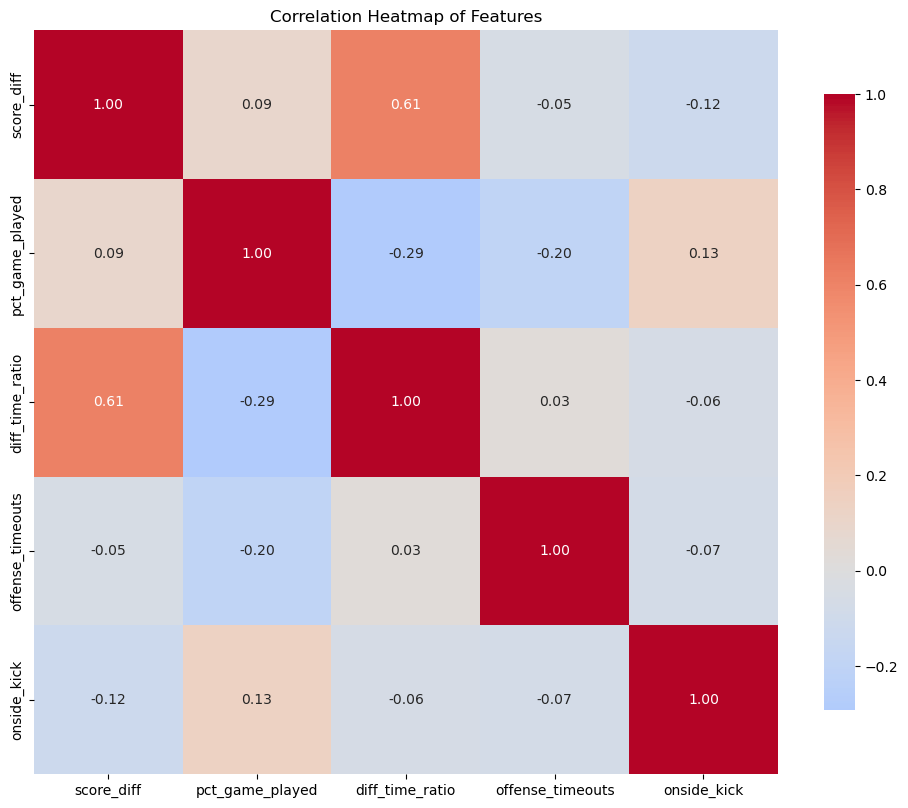

In [350]:
# correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    data.corr(), 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    center=0,
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title('Correlation Heatmap of Features')
plt.show()

In [352]:
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
SEED = 22
np.random.seed(SEED)

feature_names = [
    'score_diff', 
    'pct_game_played',
    'diff_time_ratio',
    'offense_timeouts',
]

monotonic_constraints_map = {
    "offense_timeouts": -1
}
monotonic_constraints = tuple([monotonic_constraints_map.get(feature, 0) for feature in feature_names])

# Objective function for Optuna
def objective(trial, dtrain, dvalid):
    param = {
        "nthread": -1,
        "objective": "binary:logistic",
        "monotone_constraints": monotonic_constraints,
        "eval_metric": "logloss",
        "booster": "gbtree",
        "lambda": trial.suggest_float("lambda", 1e-5, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-5, 10.0, log=True),
        "eta": trial.suggest_float("eta", 0.05, 0.3, step=0.01),
        "max_depth": trial.suggest_int("max_depth", 3, 9, step=2),
        "min_child_weight": trial.suggest_float("min_child_weight", .5, 10, step=.5),
        "gamma": trial.suggest_float("gamma", 1e-8, 5.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "seed": SEED,
    }
    
    bst = xgb.train(
        param, 
        dtrain,
        num_boost_round=500,
        evals=[(dvalid, "eval")],
        early_stopping_rounds=10,
        verbose_eval=False,
    )
    preds = bst.predict(dvalid)
  
    return log_loss(valid_y, preds)

# Create DMatrix objects
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)

# Run Optuna optimization
sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(
    study_name="onside_kick_optimization",
    direction="minimize", 
    load_if_exists=True,
    sampler=sampler
)
study.optimize(lambda trial: objective(trial, dtrain, dvalid), n_trials=50)

# Train final model with best parameters
best_params = {
    **study.best_trial.params,
    'nthread': -1,
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    # 'interaction_constraints': interaction_constraints,
    'eval_metric': 'logloss',
    'seed': SEED,
}

final_model = xgb.train(
    best_params, 
    dtrain,
    num_boost_round=500,
    evals=[(dvalid, "eval")],
    early_stopping_rounds=10,
    verbose_eval=False
)
print(f"Number of boosted rounds: {final_model.best_iteration}")

# Evaluate on train set
train_preds = final_model.predict(dtrain)
print(f"Final train log loss: {log_loss(train_y, train_preds):0.3f}")
precision, recall, _ = precision_recall_curve(train_y, train_preds)
pr_auc = auc(recall, precision)
print(f"Final train PR AUC: {pr_auc:0.3f}")

# Evaluate on validation set
valid_preds = final_model.predict(dvalid)
print(f"Final validation log loss: {log_loss(valid_y, valid_preds):0.3f}")
precision, recall, _ = precision_recall_curve(valid_y, valid_preds)
pr_auc = auc(recall, precision)
print(f"Final validation PR AUC: {pr_auc:0.3f}")

# Evaluate on test set
dtest = xgb.DMatrix(test_x, label= test_y)
test_preds = final_model.predict(dtest)
print(f"Final test log loss: {log_loss(test_y, test_preds):0.3f}")
precision, recall, _ = precision_recall_curve(test_y, test_preds)
pr_auc = auc(recall, precision)
print(f"Final test PR AUC: {pr_auc:0.3f}")

Number of boosted rounds: 115
Final train log loss: 0.037
Final train PR AUC: 0.393
Final validation log loss: 0.036
Final validation PR AUC: 0.390
Final test log loss: 0.037
Final test PR AUC: 0.416


In [353]:
p = kickoff_plays.onside_kick.value_counts(normalize=True).values[0]
baseline_log_loss = -(p * np.log(p) + (1 - p) * np.log(1 - p))
print(f"Baseline probability of kickoff attempt: {p:0.3f}")
print(f"Baseline log loss: {baseline_log_loss:0.3f}")

Baseline probability of kickoff attempt: 0.988
Baseline log loss: 0.064


/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_77058/10610399.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values,


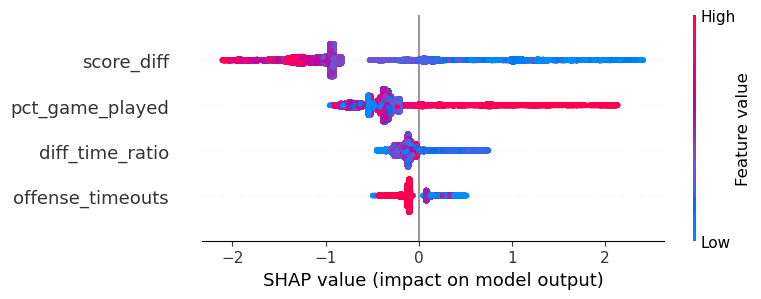

In [354]:
import shap
background = train_data[feature_names]
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(background)
shap.summary_plot(shap_values, 
                 background, 
                 plot_type="dot",  # "dot" (default), "bar", or "violin"
                 max_display=15,
                 show=True)

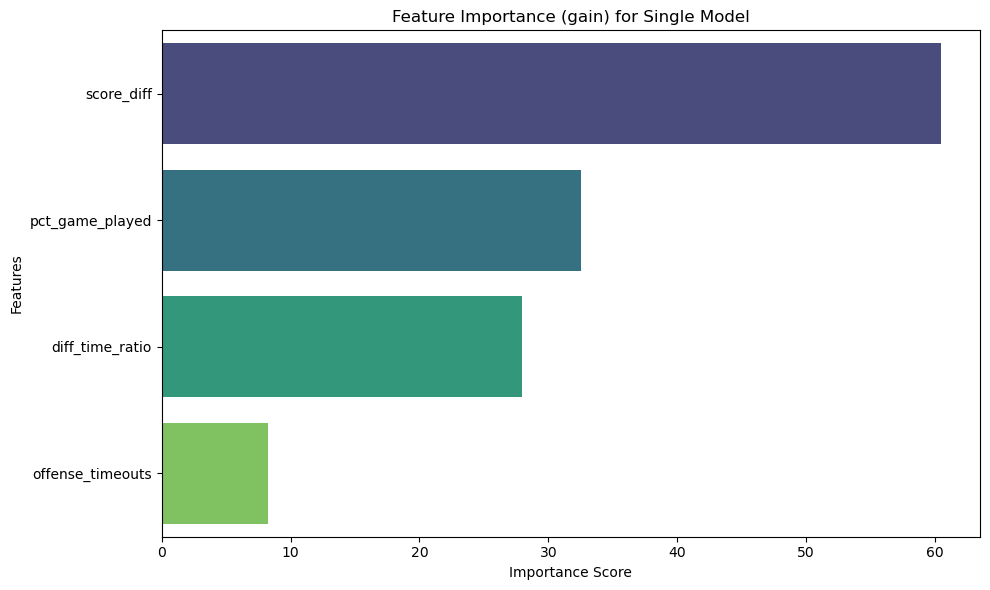

In [355]:
importance_type = "gain"  # Options: "gain", "weight", "cover"

# Get feature importance for a single model
importance = final_model.get_score(importance_type=importance_type)

# Convert to DataFrame and sort
importance_df = pd.DataFrame({
    "Feature": list(importance.keys()),
    "Importance": list(importance.values())
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance", 
    y="Feature", 
    data=importance_df, 
    palette="viridis", 
    hue="Feature", 
    dodge=False
)
plt.title(f"Feature Importance ({importance_type}) for Single Model")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.legend([], [], frameon=False)
plt.tight_layout()
plt.show()

In [356]:
# predict onside_kick_proba for all plays
kickoff_plays['onside_kick_proba'] = final_model.predict(xgb.DMatrix(kickoff_plays[feature_names]))

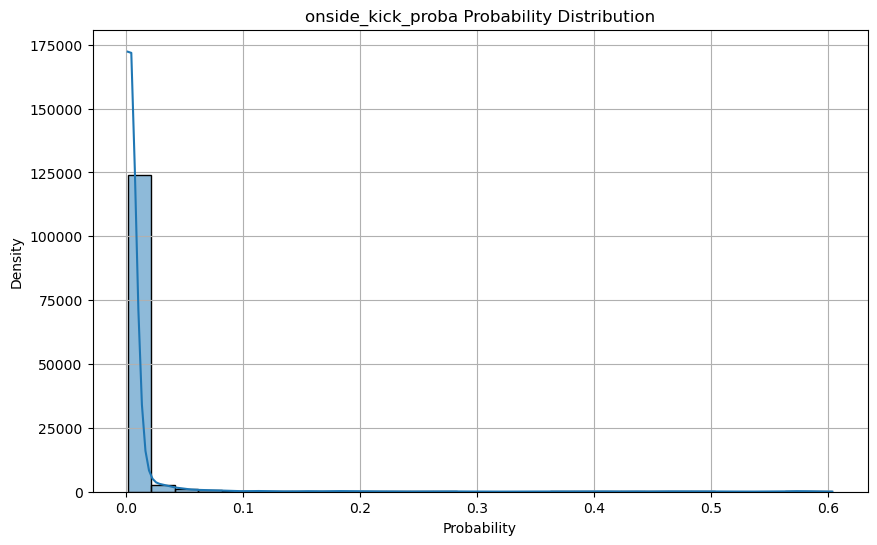

In [357]:
# plot win probability
def plot_wp(df, col):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'{col} Probability Distribution')
    plt.xlabel('Probability')
    plt.ylabel('Density')
    plt.grid()
    plt.show()
plot_wp(kickoff_plays, col='onside_kick_proba')

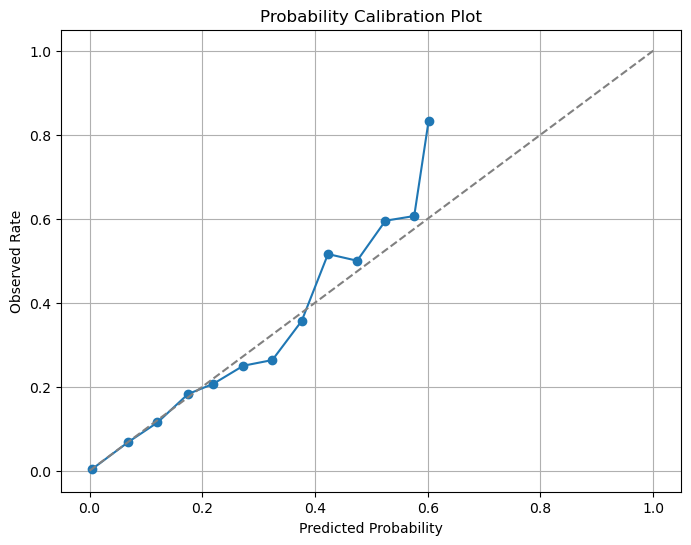

In [358]:
calibration = pd.DataFrame()
def plot_calibration(df, proba_col, actual_col, bins=100, scale=0.2):
    global calibration
    df['proba_bin'] = pd.cut(df[proba_col], bins=np.linspace(0, 1, bins + 1), labels=False, include_lowest=True)
    calibration = df.groupby('proba_bin').agg(
        predicted_proba=(proba_col, 'mean'),
        actual_proba=(actual_col, 'mean'),
        count=(proba_col, 'size')
    ).reset_index()

    plt.figure(figsize=(8, 6))
    plt.plot(calibration['predicted_proba'], calibration['actual_proba'], label='Calibration Curve', marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Observed Rate')
    plt.title('Probability Calibration Plot')
    plt.grid()
    plt.show()

plot_calibration(kickoff_plays, proba_col='onside_kick_proba', actual_col='onside_kick', bins=20)

In [360]:
kickoff_plays.sort_values(
    by='onside_kick_proba', 
    ascending=False
)[['offense','defense'] + feature_names + ['onside_kick', 'onside_kick_proba']].head(20)

,offense,defense,score_diff,pct_game_played,diff_time_ratio,offense_timeouts,onside_kick,onside_kick_proba
469926,NC State,North Carolina,-11,0.969444,-12.430057,0.0,True,0.603705
1563367,Texas Tech,TCU,-10,0.970556,-11.249941,0.0,True,0.603705
232728,Pittsburgh,Virginia,-5,0.975833,-5.507466,0.0,True,0.601086
760671,UTSA,UAB,-5,0.980278,-5.410420,0.0,True,0.601086
465023,Northern Illinois,Ohio,-5,0.970833,-5.618724,0.0,True,0.601086
242489,Georgia Tech,Duke,-6,0.975833,-6.608959,0.0,True,0.601086
1168284,UCLA,Colorado,-6,0.970833,-6.742469,0.0,True,0.601086
1368004,Kansas,West Virginia,-6,0.970833,-6.742469,0.0,False,0.601086
1162407,Boston College,Clemson,-6,0.978333,-6.543199,0.0,True,0.601086
1326926,Nebraska,Purdue,-5,0.972222,-5.587595,0.0,False,0.601086


In [361]:
model_dir = join('../models/raw', 'kickoffs')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_path = os.path.join(model_dir, f"onside_decision_xgb.bin")
final_model.save_model(model_path)

print(f"Saved model to the '{model_dir}' folder.")

Saved model to the '../models/raw/kickoffs' folder.


/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_77058/1082815795.py:6: UserWarning: [19:35:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  final_model.save_model(model_path)


## 3. Predict If Kicking Team Recovers Onside Kick

## 4. Predict the Yardline the Onside Kick is Recovered At